In [223]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from tqdm import tqdm
import math
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

# 예측
피마 인디언 당뇨 데이터

In [2]:
path = "C:\\Users\\j\\Desktop\\test\\"
d1 = pd.read_csv(path+"diabetes.csv")

## EDA

In [6]:
d1.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [4]:
d1.describe()

#수치변수간 스케일이 상이

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021E0F4042C8>,
      dtype=object)

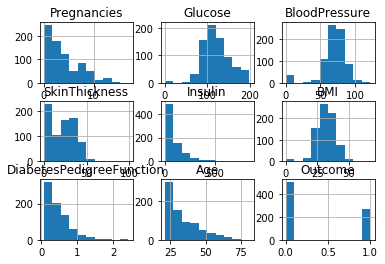

In [5]:
d1.hist()

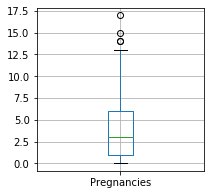

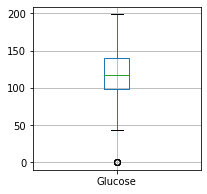

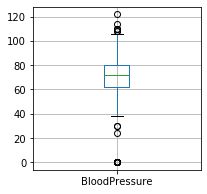

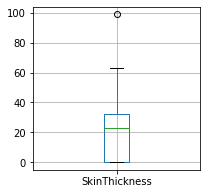

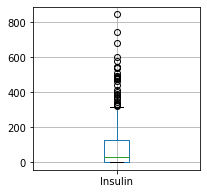

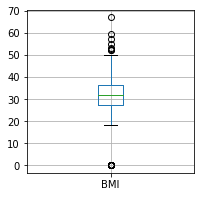

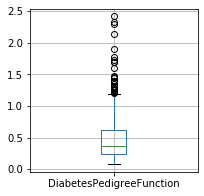

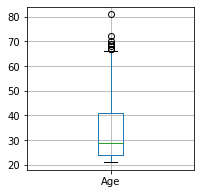

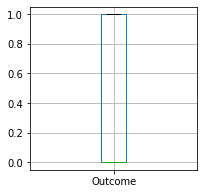

In [8]:
plt.rcParams["figure.figsize"] = (3,3)

for i, item in enumerate(list(d1.columns)[0:]):
    pd.DataFrame(d1[item]).boxplot()
    plt.show()
    

#Insulin , DiabetesPedigreeFunction  이상치 처리할 것

In [15]:
tmp = d1["Outcome"].value_counts().to_frame().reset_index()
tmp["percent"] = tmp["Outcome"].apply(lambda x: round(100*float(x)/len(d1),2))
tmp = tmp.rename(columns = {"index" : "class", 'Outcome' : "Count"})

tmp

,class,Count,percent
0,0,500,65.1
1,1,268,34.9


## 이상치 처리
https://www.kaggle.com/code/nareshbhat/outlier-the-silent-killer

In [20]:
y = d1[["Outcome"]]
X = d1.drop(["Outcome"], axis = 1)

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

**Isolation Forest**  


: 결정 트리 계열의 비지도 학습 알고리즘으로 High deimensional 데이터셋에서 이상치를 탐지할 때 효과적인 방법이다.  
데이터셋을 결정 트리형태로 표현해 정상 데이터를 분리하기 위해서는 트리의 깊이가 깊어지고 반대로 이상치는 트리 상단에서 분리할 수 있다는 개념을 이용한다.  
즉 데이터에서 이상치를 분리하는 것이 더 쉽다는 것이다.   
 따라서 특정 데이터를 데이터셋에서 분리하기 위해서는 트리에서 몇 번을 분리해야 하는지, 다시 말하면 데이터까지의 경로 길이를 기준으로 데이터가 이상치인지 아닌지를 판단한다. 이때 이상치는 다른 관측치에 비해 짧은 경로 길이를 가진 데이터 일 것이다.  

 0과 1사이로 산출되며, 1에 가까울 수록 이상치로 간주된다.   

In [51]:
def Iso_outliers(df):
    iso = IsolationForest(random_state = 0)
    clusters = iso.fit_predict(df.values.reshape(-1,1))
    data = pd.DataFrame()
    data["cluster"] = clusters
    
    print(data["cluster"].value_counts().sort_values(ascending=False))

In [58]:
X_train[["Insulin", "DiabetesPedigreeFunction"]].apply(lambda x: Iso_outliers(x))

 1    474
-1    102
Name: cluster, dtype: int64
 1    472
-1    104
Name: cluster, dtype: int64


Insulin                     None
DiabetesPedigreeFunction    None
dtype: object

**DBscan**

밀도 기반의 클러스터링 알고리즘으로 어떠한 클러스터에도 포함되지 않는 데이터를 이상치로 탐지하는 방법이다.
DBScan 알고리즘은 2가지의 하이퍼파라미터 eps 그리고 MinPts 를 요구한다.
eps : 두 데이터 사이의 거리가 eps 보다 작거나 같을 때 이들은 같은 클러스터 내에 있는 것으로 간주한다.
MinPts : 한 클러스터 내에 존재해야 하는 데이터의 최소 개수. 최소 3 이상의 값을 가져야 하며 보통은 데이터의 차원에 1을 더한 값 이상으로 설정한다.
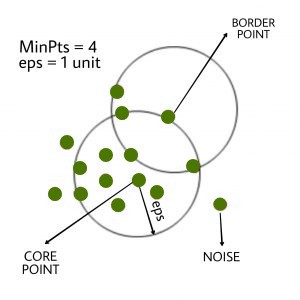

이때 eps 거리 내에 MinPts 이상의 데이터를 이웃하는 데이터는 Core Point 가 되고 반대로 eps 거리 내에 MinPts 미만의 데이터를 이웃하는 데이터는 Border Point 가 된다. 그리고 이들을 제외한 데이터가 바로 이상치가 된다.
DBScan 알고리즘은 K-means 알고리즘과 달리 클러스터의 개수를 미리 정하지 않아도 되고 클러스터가 선형적으로 나뉘지 않아 다양한 모양을 가질 수 있다.

데이터의 차원이 높을수록 정확하지 않을 수 있고, eps 하이퍼파라미터를 적절한 값으로 설정하는 것이 어렵다는 단점이 있다.  

In [45]:
def DB_outliers(df):
    dbscan = DBSCAN()
    clusters = dbscan.fit_predict(df.values.reshape(-1,1))
    data = pd.DataFrame()
    data["cluster"] = clusters
    print(data["cluster"].value_counts().sort_values(ascending = False))

In [64]:
X_train[["Insulin", "DiabetesPedigreeFunction"]].apply(lambda x:DB_outliers(x))

 0    270
-1    254
 3      9
 2      7
 7      7
 8      7
 1      6
 4      6
 5      5
 6      5
Name: cluster, dtype: int64
0    576
Name: cluster, dtype: int64


Insulin                     None
DiabetesPedigreeFunction    None
dtype: object

Insulin만 삭제하고 다른 수치형 데이터로 변환  
DiabetesPedigreeFunction는 나중에 진행할 스케일링으로 퉁..

In [157]:
X_train["clusters"] = iso.fit_predict(X_train["Insulin"].values.reshape(-1,1))

In [159]:
X_train.loc[X_train["clusters"]== -1, "Insulin"] = np.nan

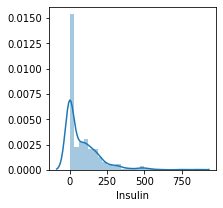

In [153]:
sns.distplot(X_train["Insulin"])
#이전 distplot

In [161]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

iter_imputer = IterativeImputer(random_state = 0)
X_train_iter = iter_imputer.fit_transform(X_train)

In [162]:
X_train_iter = pd.DataFrame(X_train_iter, columns = X_train.columns)

In [163]:
X_train_iter["Insulin"].value_counts()

0.000000      270
105.000000      9
130.000000      7
180.000000      7
120.000000      7
             ... 
96.066589       1
74.492010       1
53.709615       1
132.000000      1
66.727172       1
Name: Insulin, Length: 192, dtype: int64

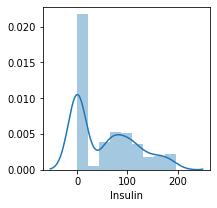

In [164]:
sns.distplot(X_train_iter["Insulin"])

In [165]:
from sklearn.impute import KNNImputer

knn = KNNImputer(n_neighbors=3)
X_train_knn = knn.fit_transform(X_train)

In [166]:
X_train_knn = pd.DataFrame(X_train_knn, columns = X_train.columns)

In [167]:
X_train_knn["Insulin"].value_counts()

0.000000      276
105.000000      9
120.000000      7
130.000000      7
180.000000      7
             ... 
93.333333       1
148.333333      1
25.333333       1
144.333333      1
133.333333      1
Name: Insulin, Length: 152, dtype: int64

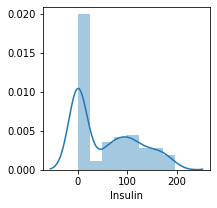

In [168]:
sns.distplot(X_train_knn["Insulin"])

In [170]:
X_train["Insulin"].d

count    474.000000
mean      50.592827
std       64.211273
min        0.000000
25%        0.000000
50%        0.000000
75%      105.000000
max      196.000000
Name: Insulin, dtype: float64

#### 무언가의 시도..

In [81]:
 X_train.loc[X_train["clusters"]== -1]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,clusters
127,1,118,58,36,94,33.3,0.261,23,-1
375,12,140,82,43,325,39.2,0.528,58,-1
663,9,145,80,46,130,37.9,0.637,40,-1
144,4,154,62,31,284,32.8,0.237,23,-1
609,1,111,62,13,182,24.0,0.138,23,-1
...,...,...,...,...,...,...,...,...,...
277,0,104,64,23,116,27.8,0.454,23,-1
723,5,117,86,30,105,39.1,0.251,42,-1
359,1,196,76,36,249,36.5,0.875,29,-1
707,2,127,46,21,335,34.4,0.176,22,-1


In [148]:
d1_2 = d1.loc[d1["Outcome"] == 1]

d1_3 = d1.loc[d1["Outcome"] == 0]

----------------------------------------------

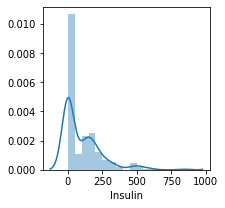

In [149]:
sns.distplot(d1_2["Insulin"])

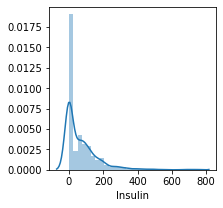

In [150]:
sns.distplot(d1_3["Insulin"])

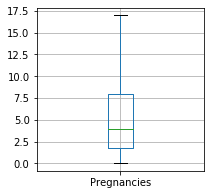

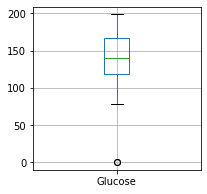

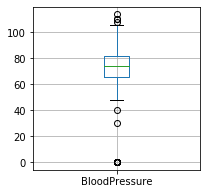

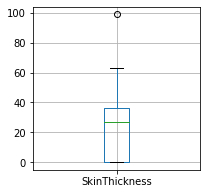

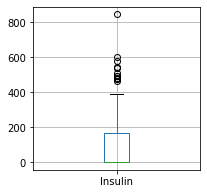

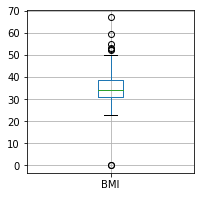

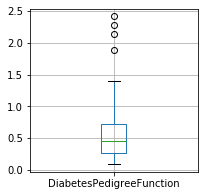

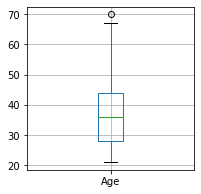

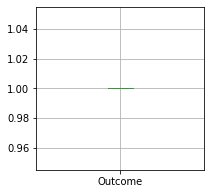

In [90]:
plt.rcParams["figure.figsize"] = (3,3)

for i, item in enumerate(list(d1_2.columns)[0:]):
    pd.DataFrame(d1_2[item]).boxplot()
    plt.show()

In [109]:
d1_2["clusters"] = dbscan.fit_predict(d1_2["Insulin"].values.reshape(-1,1))


d1_2.loc[d1_2["clusters"]== -1,"Insulin"] = np.nan

In [127]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

iter_imputer = IterativeImputer(random_state = 0)
d1_2_iter = iter_imputer.fit_transform(d1_2)

In [129]:
d1_2_iter = pd.DataFrame(d1_2_iter, columns = d1_2.columns)

In [134]:
d1_2_iter["Insulin"].value_counts()

0.0    268
Name: Insulin, dtype: int64

In [136]:
from sklearn.impute import KNNImputer

knn = KNNImputer(n_neighbors=3)
d1_2_knn = knn.fit_transform(d1_2)

In [139]:
d1_2_knn = pd.DataFrame(d1_2_knn, columns = d1_2.columns)

In [141]:
d1_2_knn["Insulin"].value_counts()

0.0    268
Name: Insulin, dtype: int64

Revenu_Millions를 볼 때 데이터가 한쪽으로 매우 치우쳐져 있습니다.
이런 분포는 항상 평균과 중위수의 차이를 확인해봐야합니다. (평균: 82.96, 중위수: 47.98)
따리서, 이런 분포의 데이터의 결측치는 평균으로 대체하면 매우 위험합니다.
평균은 극단값(Outlier)에 영향을 받기 때문입니다. 극단값은 패턴을 벗어난 특수한 상황이지, 결코 일반적인 상황을 대변해주지 않습니다.

## 앞선 두 단계에서 얻은 향후 분석시 고려사항 작성

Insulin을 볼 때 데이터가 한쪽으로 매우 치우쳐져 있습니다. 이런 분포는 항상 평균과 중위수의 차이를 확인해봐야 함. (평균:50.59, 중위수: 0) 따리서, 이런 분포의 데이터의 결측치는 평균으로 대체하면 매우 위험합니다. 평균은 극단값(Outlier)에 영향을 받기 때문입니다. 극단값은 패턴을 벗어난 특수한 상황이지, 결코 일반적인 상황을 대변해주지 않음

# 데이터 보완

## 오버샘플링 과정 설명하고 결과 작성

In [187]:
X_train_iter = X_train_iter.drop(["clusters"], axis = 1)

In [188]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 0)

X_train_over, y_train_over = smote.fit_resample(X_train_iter, y_train)

print("오버샘플링 이전:", X_train_iter.shape, y_train.shape)
print("오버샘플링 이후:", X_train_over.shape, y_train_over.shape)

print(y_train_over.value_counts())

오버샘플링 이전: (576, 8) (576, 1)
오버샘플링 이후: (740, 8) (740, 1)
Outcome
0          370
1          370
dtype: int64


## 언더샘플링 과정 설명하고 결과 작성

In [189]:
from imblearn.under_sampling import RandomUnderSampler

ru = RandomUnderSampler(random_state = 0)

X_train_under, y_train_under = ru.fit_resample(X_train_iter, y_train)

print("오버샘플링 이전:", X_train_iter.shape, y_train.shape)
print("오버샘플링 이후:", X_train_under.shape, y_train_under.shape)

print(y_train_under.value_counts())

오버샘플링 이전: (576, 8) (576, 1)
오버샘플링 이후: (412, 8) (412, 1)
Outcome
0          206
1          206
dtype: int64


##  둘 중 선택하고 이유 설명

정보 손실의 이유로 오버샘플링 채택 

# 모델링 구현

## 최소 3개 이상 알고리즘 제시하고 정확도 측면의 모델 1개와 속도 측면의 모델 1개를 꼭 구현(총 2개 이상)

1. xgboost (정확도)
2. logistic regression (속도)
3. enesemble radomforest classification

In [197]:
X_train_over

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,9.000000,89.000000,62.000000,0.000000,0.000000,22.500000,0.142000,33.000000
1,1.000000,118.000000,58.000000,36.000000,94.000000,33.300000,0.261000,23.000000
2,0.000000,91.000000,80.000000,0.000000,0.000000,32.400000,0.601000,27.000000
3,12.000000,140.000000,82.000000,43.000000,76.085050,39.200000,0.528000,58.000000
4,9.000000,145.000000,80.000000,46.000000,130.000000,37.900000,0.637000,40.000000
...,...,...,...,...,...,...,...,...
735,2.431272,114.274911,73.241696,28.104241,0.000000,30.803781,0.207806,27.085335
736,7.407112,125.000000,70.000000,22.542816,118.025036,30.149274,0.610787,42.728592
737,3.735058,157.504269,89.008538,0.000000,0.000000,29.914515,0.662477,62.777749
738,3.318409,154.296022,74.148011,0.000000,0.000000,46.527863,0.254358,31.318409


In [203]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train_over)
X_train_scaled = scaler.transform(X_train_over)
X_test_scaled = scaler.transform(X_test)

In [190]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, confusion_matrix, plot_roc_curve, f1_score

def metrics(y_real, y_pred):
    accuracy = accuracy_score(y_real, y_pred)
    recall = recall_score(y_real, y_pred)
    precision = precision_score(y_real, y_pred)
    f1 = f1_score(y_real, y_pred)
    matrix = confusion_matrix(y_real, y_pred)
    
    print("accuarcy: ", accuracy, "\n")
    print("recall: ", recall, "\n")
    print("precision", precision, "\n")
    print("f1: ", f1, "\n")
    print("matrix: ","\n", matrix)

In [191]:
def modeling (X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #df = pd.DataFrame(y_pred)
    #df.to_csv("C:\\Users\\j\\Desktop\\test\\"+file_name+".csv", index = False)
    y_real = y_test
    print(model)
    
    metrics(y_real, y_pred)
    print("\n")

In [181]:
from xgboost import XGBClassifier

In [182]:
xg = XGBClassifier(random_state=0)

In [193]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [192]:
modeling(X_train_over, X_test, y_train_over, y_test, xg)

[21:25:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
accuarcy:  0.78125 

recall:  0.6935483870967742 

p

In [195]:
modeling(X_train_over, X_test, y_train_over, y_test, lr)

LogisticRegression()
accuarcy:  0.78125 

recall:  0.7419354838709677 

precision 0.6388888888888888 

f1:  0.6865671641791045 

matrix:  
 [[104  26]
 [ 16  46]]




In [295]:
import time
start = time.time()  # 시작 시간 저장
 
modeling(X_train_scaled, X_test_scaled, y_train_over, y_test, xg)
 
print("time :", time.time() - start)

[18:16:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
accuarcy:  0.78125 

recall:  0.6935483870967742 

p

In [296]:
import time
start = time.time()  # 시작 시간 저장
 
modeling(X_train_scaled, X_test_scaled, y_train_over, y_test, lr)
 
print("time :", time.time() - start)

LogisticRegression()
accuarcy:  0.7760416666666666 

recall:  0.7258064516129032 

precision 0.6338028169014085 

f1:  0.6766917293233083 

matrix:  
 [[104  26]
 [ 17  45]]


time : 0.03747844696044922


## 모델 비교하고 결과 설명

|모델|성능|시간
|---|---|---|
LogisticRegression|0.676|0.03
Xgboos|0.671|0.24

## 속도 개선을 위한 차원 축소 설명하고 수행, 예측 성능과 속도 비교하고 결과 작성

In [292]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [297]:
import time
start = time.time()  # 시작 시간 저장
 
modeling(X_train_pca, X_test_pca, y_train_over, y_test, xg)
 
print("time :", time.time() - start)

[18:17:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
accuarcy:  0.6510416666666666 

recall:  0.612903225

In [298]:
import time
start = time.time()  # 시작 시간 저장
 
modeling(X_train_pca, X_test_pca, y_train_over, y_test, lr)
 
print("time :", time.time() - start)

LogisticRegression()
accuarcy:  0.703125 

recall:  0.6129032258064516 

precision 0.5352112676056338 

f1:  0.5714285714285713 

matrix:  
 [[97 33]
 [24 38]]


time : 0.032375335693359375


|pca 유무|성능|시간
|---|---|---|
PCA 이전 lr|0.676|0.03
PCA 이후 lr|0.535|0.03

# 분산 검정

금속 성분 함유량 데이터(변수 1개) - 제품에 금속 재질 함유량의 분산이 1.3을 넘으면 불량이라고 보고 있는데 제조사별로 차이가 난다고 제보를 받았으며, 분산에 대해 검정을 수행하시오. (유의확률 0.05)

In [206]:
path = "C:\\Users\\j\\Desktop\\test\\"
d2 = pd.read_csv(path+"content.csv")

In [208]:
from scipy.stats import chisquare

In [212]:
chisquare(d2.values)

Power_divergenceResult(statistic=array([4.2608244]), pvalue=array([1.]))

## 연구가설과 귀무가설 작성

영가설 :  분산 1.3 보다 작다   
귀무가설 : 분산 1.3 크다   

##  양측 검정
내맘대로 단측검정  

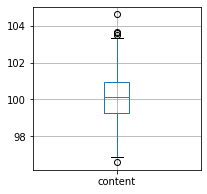

In [214]:
d2.boxplot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021E28A4D188>]],
      dtype=object)

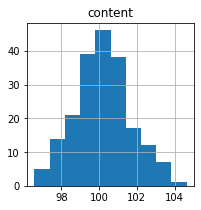

In [215]:
d2.hist()

In [220]:
ddof = len(d2) - 1

In [230]:
stats.chi2.ppf(0.95, ddof)


# scipy.stats.chi2.ppf(q, df)
# q -> the significance level to use
# df -> the degrees of freedom

232.91182176847582

## 검정통계량, 가설 채택

In [221]:
s2 = np.var(d2)

In [225]:
chi = len(d2) - 1 * s2 / math.pow(1.3,2)
chi

content    198.737337
dtype: float64

카이제곱통계량 198, 기각역 232이므로   
검정통계량은 채택역 안에 위치하여 분산이 1.3보다 작다.  

# Lot 별 불량 제품 수량 데이터

In [231]:
path = "C:\\Users\\j\\Desktop\\test\\"
d3 = pd.read_csv(path+"error.csv")

## 불량률 관리도에 따라 관리중심선(CL : Center Line), 관리 상한선(UCL : Upper Control Limit), 하한선(LCL : Lower Control Limit) 구하기

관리도란 품질의 산포를 관리하게 위해 관리 한계선이 있는 그래프를 말하며, 이것을 사용하는 방법을 말한다.  

P관리도 : 각 부분군에 있는 불량품의 비율을 나타냄  
NP관리도 : 각 부분군에 있는 불량품의 개수를 나타냄  
C관리도 : 각 부분군에 있는 결점의 개수를 나타냄  
U관리도 : 각 부분군에서 단위당 결점의 개수를 나타냄 

관리도는 관리상태에서의 품질특성치의 평균을 나타내는 중심선(CL),  
관리상한선, 관리하한선으로 구성된다.  

샘플들을 추출하여 계산한 값들을 관리도 상에 점으론 나타냈을 때 모든 점들이 관리한계선 사이에 놓이고, 점들의 형태를 볼 때 관리상태를 이탈했다고 판단할 만한 별다른 징후가 없으면 공정이 관리상태에 있다고 한다.  

관리한계선의 폭을 설정하는 데는 계산상의 편의를 고려하여 표준편차의 배수를 이용할 수 있다. 보통 그 배수로서 3을 사용하는데 이떄의 관리한계선을 3σ관리한계선이라 부른다.  

**<슈하르트 관리도>**  
UCL = μ + 3σ  
CL = μ   
LCL = μ - 3σ  

관리도의 X축은 시간을, Y축은 데이터 단위  
샘플의 평균을 나타낸 중앙선에, 관리한계(UCL, LCL)를 X축과 평행으로 그리기 

https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=easternsun&logNo=220075418507

#### 불량률 P관리도 VER

In [273]:
n = 200

In [275]:
error_rate = sum(d3["error_case_number"]/n)

In [276]:
s = np.sqrt((error_rate*(1-error_rate)/n))

In [282]:
np.sqrt(error_rate * (1 - error_rate) / n)

nan

In [278]:
UCL = error_rate + 3 * s
LCL = error_rate - 3 * s

print("UCL", UCL)
print("LCL", LCL)

UCL nan
LCL nan


n개인 표본 중에 포함된 부적합품의 개수를 x라고 하면 x는 이항분포를 따른다. 
E(x) = np 

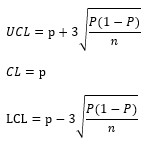

In [267]:
mu = 200 * error_rate
mu

340.99999999999983

#### NP관리도 VER

In [239]:
mu = d3["error_case_number"].mean()
std = np.std(d3["error_case_number"])

In [242]:
UCL = mu + 3 * std
LCL = mu - 3 * std

print("UCL: ", UCL)
print("LCL: ", LCL)

UCL:  13.308590808796978
LCL:  -6.488590808796978


## 관리도 시각화

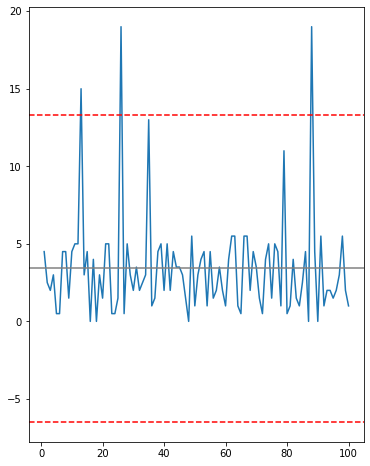

In [258]:
plt.rcParams["figure.figsize"] = (6,8)
plt.plot(d3["iot_number"], d3["error_case_number"])


plt.axhline(mu, color =  "gray")
plt.axhline(UCL, color = "red", linestyle = "--")
plt.axhline(LCL, color = "red", linestyle = "--")

plt.show()



# 연관성 검정
상품 a와 b가 있을 때 다음과 같은 구매 패턴이 있다고 한다. aa bb aaaa bbbb a b aa bb aa bbb aa bb a b 구매하는 패턴으로 보아 두 상품이 연관이 있는지 확인하라

pattern = ["A","A", "B", "B", "A", "A", "A", "A", "B", "B", "B", "B", "A", "B", "A", "A", "B", "B", "A", "A", "B", "B", "B", "A", "A", "B", "B", "A", "B"]

## 연구가설과 귀무가설 작성

영가설 : 구매패턴 없  
귀무가설 : 있  

## 평균과 표준편차

A = 0  
B = 1  

머지?

## 가설 채택

In [259]:
from statsmodels.sandbox.stats.runs import Runs

In [287]:
x = [0,0,1,1,0,0,0,0,1,1,1,1,0,1,0,0,1,1,0,0,1,1,1,0,0,1,1,0,1]

In [288]:
x = np.array(x)

In [289]:
Runs(x).runs_test()

(-0.3721438547031917, 0.7097857460625617)

z값은 -0.37, 0.7로이 도출됨으로써 유의하지 않으므로 귀무가설을 기각하지 않는다. 구매 패턴이 없다고 말할 수 있다. 